In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p,inv_boxcox1p
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
import seaborn as sb
import matplotlib.pyplot as plt
from collections import Counter
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_log_error
from matplotlib import pyplot as plt
import warnings 
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

train=pd.read_csv("../input/train.csv")
test=pd.read_csv("../input/test.csv")
print("Shapes : train set = {}, test set = {}".format(train.shape,test.shape))


Using TensorFlow backend.


['test.csv', 'train.csv', 'sample_submission.csv']
Shapes : train set = (3000, 23), test set = (4398, 22)


Output (revenue) from the trainset is isolated in y_train 

Train and test sets are merged in order to facilitate preprocessing. 

Datasets will be splitted again after preprocessing

In [2]:
y_train=train["revenue"]
train = train.drop("revenue", axis=1)
test.index = test.index + len(train.index)
data = pd.concat([train, test])

We first delete the useless features that we will never use

In [3]:
data = data.drop(["id", "imdb_id", "original_title", "title", "status", "poster_path"], axis=1)

Then, we create the new features we want to use as well as delete the feature we will not need anymore. 

In [4]:
# Format the json features to list

json_features = ["belongs_to_collection", "genres", "production_companies", "cast", "crew", "production_countries", "Keywords"]

# Preparing the space needed to store the directors and producers of each movie
data["director"]=[[] for i in range(data.shape[0])]
data["producer"]=[[] for i in range(data.shape[0])]

for f in json_features:
    data.loc[data[f].notnull(),f]= data.loc[data[f].notnull(),f].apply(lambda x : ast.literal_eval(x))
    if (f == "cast"):
        #Extracting cast number before editing cast
        data["cast_number"] = data.loc[data["cast"].notnull(),"cast"].apply(lambda x : len(x))
        # We keep only the top 3 actors of each movie
        data.loc[data["cast"].notnull(),"cast"] = data.loc[data["cast"].notnull(),"cast"].apply(lambda x : [y["name"] for y in x if y["order"]<10]) 
    if (f == "crew"):
        #Extracting crew data (number, director, producer)
        data["crew_number"] = data.loc[data["crew"].notnull(),"crew"].apply(lambda x : len(x))      
        data["director"]=data.loc[data["crew"].notnull(),"crew"].apply(lambda x : [y["name"] for y in x if y["job"]=="Director"])
        data["producer"]=data.loc[data["crew"].notnull(),"crew"].apply(lambda x : [y["name"] for y in x if y["job"]=="Producer" or y["job"] =="Executive Producer"])

    if (f!= "crew" and f!="cast"):
        data.loc[data[f].notnull(),f]= data.loc[data[f].notnull(),f].apply(lambda x : [y["name"] for y in x])

# Crew is useless now
data = data.drop("crew", axis=1)

# Let's define some "count" features 

data["genre_number"]=data.loc[data["genres"].notnull(),"genres"].apply(lambda x : len(x))
data['tagline_word_count'] = data['tagline'].str.split().str.len()

data["production_companies_number"]=data.loc[data["production_companies"].notnull(),"production_companies"].apply(lambda x : len(x))
data["production_countries_number"]=data.loc[data["production_countries"].notnull(),"production_countries"].apply(lambda x : len(x))

data["keywords_number"] = data.loc[data["Keywords"].notnull(), "Keywords"].apply(lambda x : len(x))

data["languages_number"] = data.loc[data["spoken_languages"].notnull(), "spoken_languages"].apply(lambda x : len(x))

# Let's define some features showing the presence of an attribute

data.loc[data["homepage"].notnull(),"has_homepage"]=1
data.loc[data["homepage"].isnull(),"has_homepage"]=0

data.loc[data["overview"].notnull(),"has_overview"]=1
data.loc[data["overview"].isnull(),"has_overview"]=0

data["is_in_collection"]=1
data.loc[data["belongs_to_collection"].isnull(),"is_in_collection"]=0

# Let's define features related to date of release

release_date = pd.to_datetime(data["release_date"])

data["release_day"] = release_date.dt.day
data["release_weekday"] = release_date.dt.dayofweek
data["release_month"] = release_date.dt.month
data["release_year"] = release_date.dt.year

data = data.drop(["release_date", "homepage", "overview", "overview", "belongs_to_collection", "spoken_languages", "tagline", "original_language"], axis=1)


Once we have done the adding of all the features we wanted, we fill the missing values in our dataset.

In [5]:

for f in ["Keywords", "production_companies", "production_countries", "producer", "director", "cast", "genres"]:
    data[f] = data[f].apply(lambda x: x if isinstance(x, list) else [])
for f in ["tagline_word_count", "keywords_number", "production_companies_number", "production_countries_number", "languages_number", "crew_number", "cast_number","genre_number","runtime", "release_year", "release_month", "release_day", "release_weekday"]:
    data[f] = data[f].fillna(0)

Manage the skewness : 

In [6]:
numeric=[feat for feat in data.columns if data[feat].dtype!="object"]

skewness=data[numeric].apply(lambda x : skew(x)).sort_values(ascending=False)
skew=skewness[skewness>2.5]
print(skew)

popularity                     19.960329
keywords_number                 3.123832
production_countries_number     2.990402
budget                          2.891855
cast_number                     2.809725
languages_number                2.549396
dtype: float64


Then we want to transform all the quantitative non binary features in order to make them be close to Normal distribution. 

In [7]:
high_skew=skew[skew>10].index
medium_skew=skew[skew<=10].index

for feat in high_skew:
    data[feat]=np.log1p(data[feat])

for feat in medium_skew:
    data[feat]=boxcox1p(data[feat],0.15)

In [8]:
skew=data[skew.index].skew()
print(skew)

popularity                    -0.437615
keywords_number               -0.309683
production_countries_number    1.332405
budget                        -0.476944
cast_number                    0.220478
languages_number              -0.403609
dtype: float64


Once we have done all that, it is interesting to see how our quantitative features are 
correlated with the revenue (or more precisely with our transformation of the revenue).

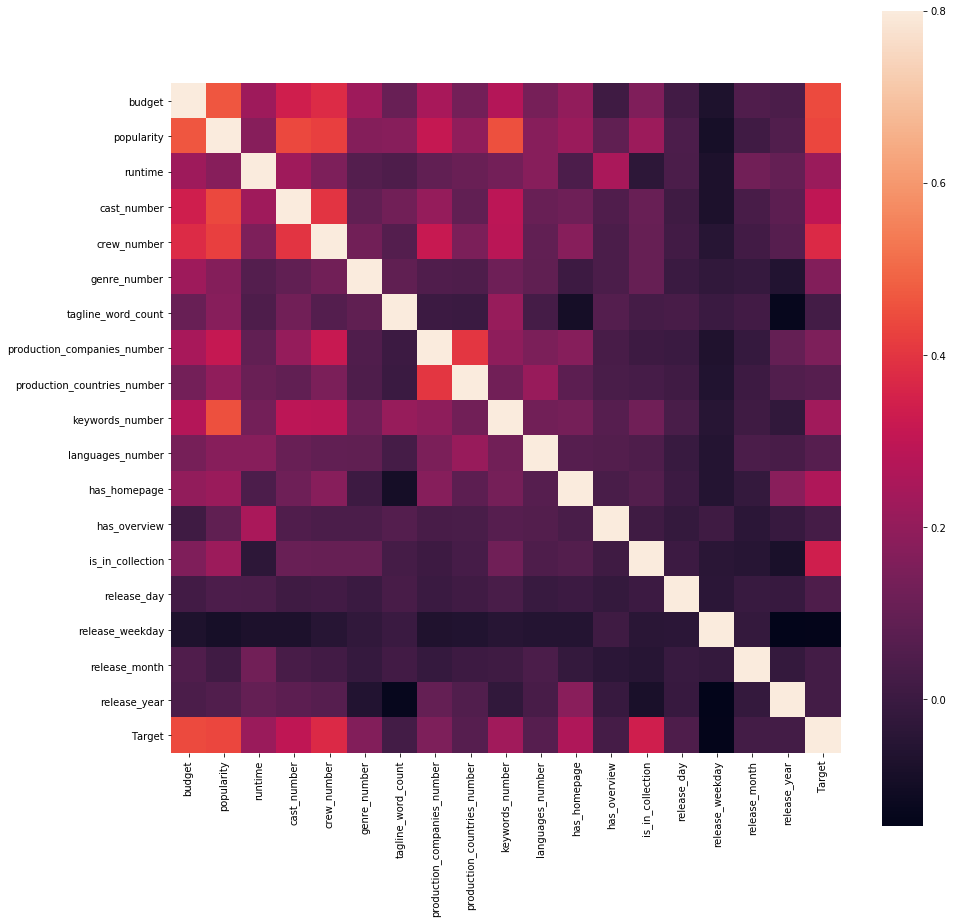

budget                         0.442633
popularity                     0.435035
runtime                        0.216230
cast_number                    0.298535
crew_number                    0.372110
genre_number                   0.163654
tagline_word_count             0.020587
production_companies_number    0.155700
production_countries_number    0.066380
keywords_number                0.231523
languages_number               0.066577
has_homepage                   0.263179
has_overview                   0.023361
is_in_collection               0.339425
release_day                    0.045699
release_weekday               -0.141090
release_month                  0.020164
release_year                   0.020593
Target                         1.000000
Name: Target, dtype: float64

In [9]:
ntrain = train.shape[0]
train_data = data.iloc[:ntrain,:] 
train_data['Target'] = y_train
C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()
train_data.corr().loc["Target"]

From this graph we can see which of our quantitative variables are important with respect to the revenues. 

In [10]:
data.shape

(7398, 25)

For all non quantitative features, we need to generate a quantitative equivalent that will be used for the train of our model.
In order to do so, we create a binary feature for each possible value of all non quantitative feature that are enough represented. This representation creteria is defined by the variable "famous_thresholds".

Then, we need to handle the non-quantitative features in order to inclue them into our model. 

In order to do so, we decide to create a feature for : 
* each of the top 5 genres
* each of the top 50 production companies
* each of the top 5 production countries
* each of the top 30 cast members
* each of the top 10 keywords
* each of the top 30 directors
* each of the top 30 producers


Therefore, we first generate all the list of top values.

In [11]:
features_to_work_on = ["genres", "production_companies", "production_countries", "cast","Keywords", "director", "producer"]
top_x_thresholds = [5, 50, 5, 30, 10, 30, 30]


def count(values, top_list):
    count = 0
    for elem in values:
        if elem in top_list:
            count += 1
    return count

for i,f in enumerate(features_to_work_on):
    list_of_values = list(data.loc[data[f].notnull(),f].values)
    top_values = [m[0] for m in Counter([i for j in list_of_values for i in j]).most_common(top_x_thresholds[i])]
    print("Top values of " + f + ":")
    print(top_values)
    
    # We then add our feature for all the top values. 
    
    data["count_top_" + f] = data.loc[data[f].notnull(), f].apply(lambda x : count(x, top_values))
    
    for t in top_values:
        data[ f + '_' + t] = data.loc[data[f].notnull(), f].apply(lambda x: 1 if t in x else 0)
    data=data.drop(f,axis=1)



Top values of genres:
['Drama', 'Comedy', 'Thriller', 'Action', 'Romance']
Top values of production_companies:
['Warner Bros.', 'Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Columbia Pictures', 'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema', 'Touchstone Pictures', 'Walt Disney Pictures', 'Columbia Pictures Corporation', 'Canal+', 'TriStar Pictures', 'Relativity Media', 'United Artists', 'Miramax Films', 'Village Roadshow Pictures', 'Regency Enterprises', 'DreamWorks SKG', 'Fox Searchlight Pictures', 'Amblin Entertainment', 'Lionsgate', 'StudioCanal', 'Working Title Films', 'Dune Entertainment', 'Summit Entertainment', 'Dimension Films', 'BBC Films', 'Orion Pictures', 'Hollywood Pictures', 'Fox 2000 Pictures', 'Film4', 'Imagine Entertainment', 'New Regency Pictures', 'Focus Features', 'Castle Rock Entertainment', 'The Weinstein Company', 'Silver Pictures', 'Lions Gate Films', 'Legendary Pictures', 'Morgan Creek Productions', 'Scott Rudin Producti

In [12]:
data.shape

(7398, 185)

In order to increase model efficiency, we want to make our target data as close as a normal variable distribution
To do so, we plot its distribution and its probability plot before and after different power transformations

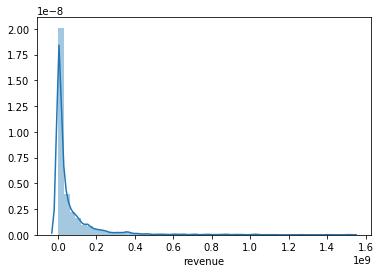

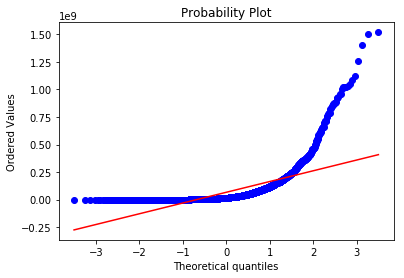

Log power transformation


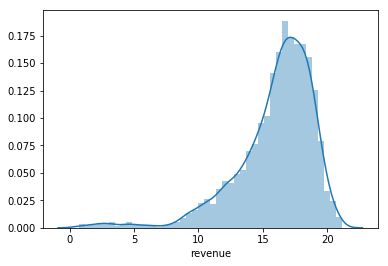

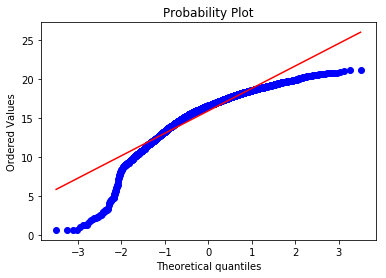

Boxcox power transformation with alpha = 0.00


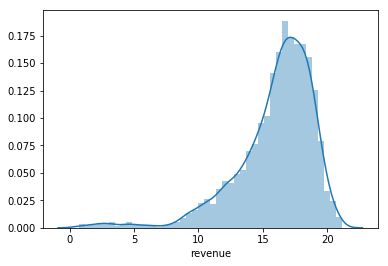

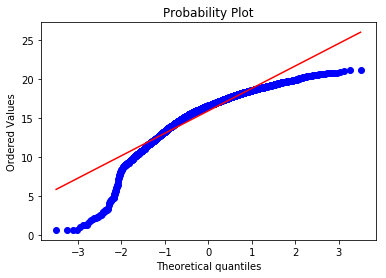

Boxcox power transformation with alpha = 0.10


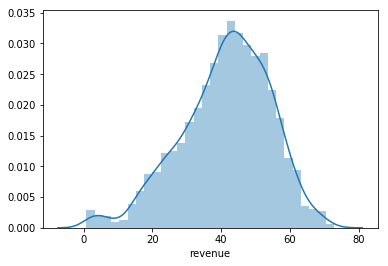

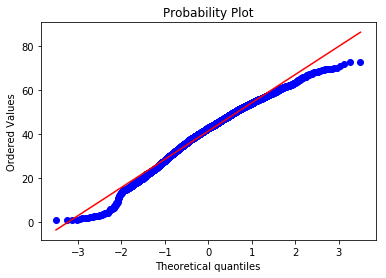

Boxcox power transformation with alpha = 0.20


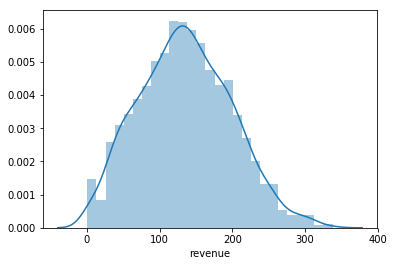

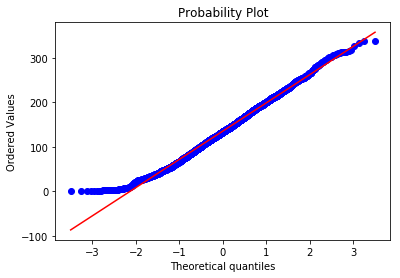

Boxcox power transformation with alpha = 0.30


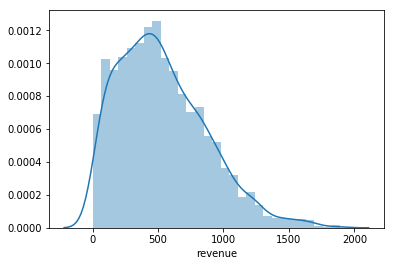

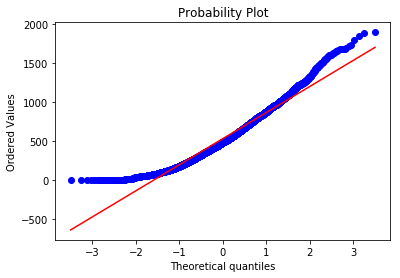

Boxcox power transformation with alpha = 0.40


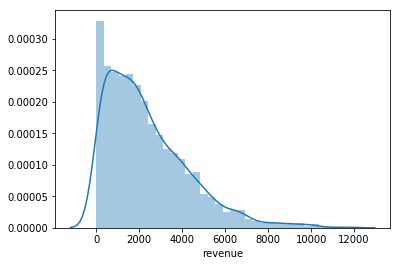

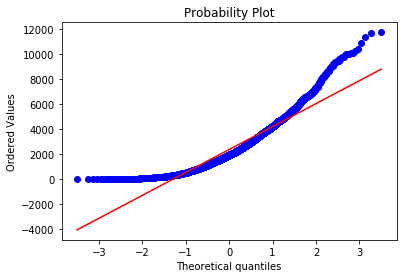

Boxcox power transformation with alpha = 0.50


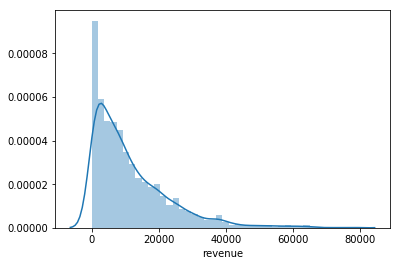

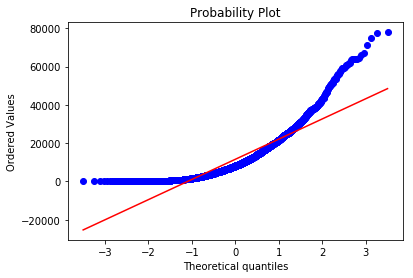

Boxcox power transformation with alpha = 0.60


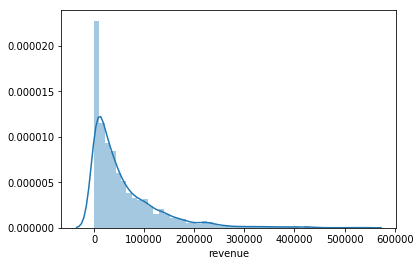

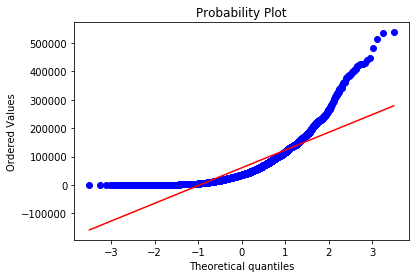

Boxcox power transformation with alpha = 0.70


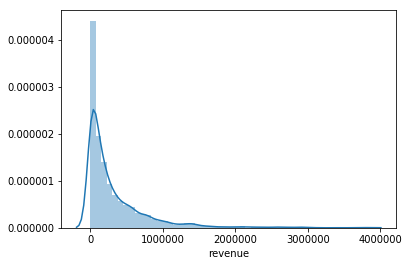

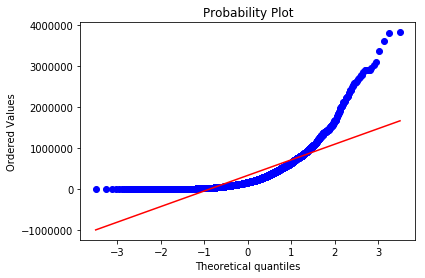

Boxcox power transformation with alpha = 0.80


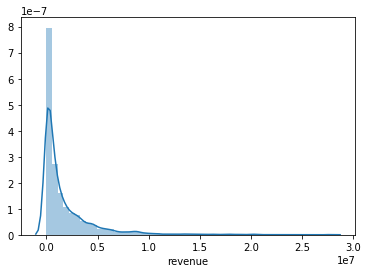

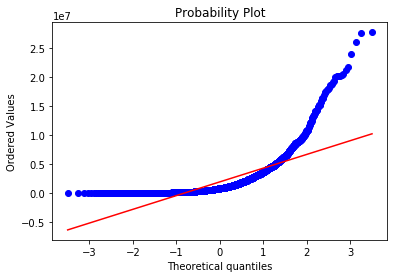

Boxcox power transformation with alpha = 0.90


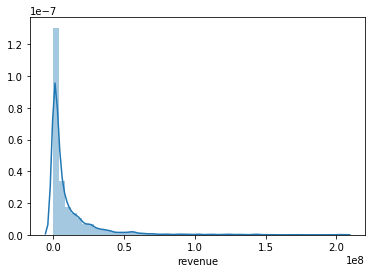

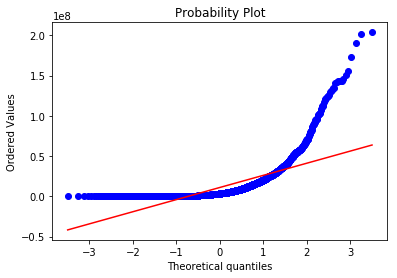

In [13]:
def distribution(y):
    sns.distplot(y)
    plt.show()
    
def probplot(y):
    stats.probplot(y,plot=plt)
    plt.show()

# Before any power transformations
distribution(y_train)
probplot(y_train)

# With the log power transformations
print('Log power transformation')
y_train_t =np.log1p(y_train) 
distribution(y_train_t)
probplot(y_train_t)

# With boxcox power transformations with different power parameters
for i in np.arange(0,1,0.1):
    print('Boxcox power transformation with alpha = %.2f' % i)
    y_train_t =boxcox1p(y_train,i) 
    distribution(y_train_t)
    probplot(y_train_t)



The best choice is boxcox with power parameters 0.2

In [14]:
y_train = boxcox1p(y_train, 0.2)

Once we have finished all the transformations, we split our data into the train and test set. 

In [15]:
ntrain=train.shape[0]

train=data.iloc[:ntrain,:]
test=data.iloc[ntrain:,:]
print("The shape of train DataFrame is {} and the shape of the test DataFrame is {}".format(train.shape,test.shape))


The shape of train DataFrame is (3000, 185) and the shape of the test DataFrame is (4398, 185)


The score function used in the leaderboard is the following : 

In [16]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y,y0): return np.sqrt(mean_squared_log_error(y, y0))

Split the data into train and validation set: 

In [17]:
def split_combined(d):
    tr = d[:2500]
    te = d[2500:]

    return tr , te 
  
x_train_val, x_validation = split_combined(train)
y_train_val, y_validation = split_combined(y_train)

At this step, all our data is prepared. We therefore need to build a model in order to make our predictions. 
In this project, we decide to build the following models to make the best predictions : 

* Linear Regression
* Random forest
* XGB Regressor

In [18]:
def LinearRegr(train, y_train):
    reg = LinearRegression()
    model_lr = reg.fit(train.values,y_train)
    return model_lr
    

In [19]:
def RandomForest(train, y_train):
    model_rf = RandomForestRegressor()
    model_rf.fit(train,y_train)
    return model_rf

In [20]:
def XGBRegr(train, y_train):
    model_xgb = XGBRegressor()
    model_xgb.fit(train,y_train, verbose=False)
    return model_xgb
    

Once all our models are defined, we use the train set and validation set (which is used as a test set in our case, as we dont have a y values for the main test set: 

In [21]:
linear_pred = LinearRegr(x_train_val, y_train_val).predict(x_validation)
randomf_pred = RandomForest(x_train_val, y_train_val).predict(x_validation)
xgb_pred = XGBRegr(x_train_val, y_train_val).predict(x_validation)

Once we have predicted all the results, we test our results against our validation set. 

In [22]:
linear_score = rmsle(inv_boxcox1p(linear_pred, 0.2), inv_boxcox1p(y_validation, 0.2))
randomf_score = rmsle(inv_boxcox1p(randomf_pred, 0.2), inv_boxcox1p(y_validation, 0.2))
xgb_score = rmsle(inv_boxcox1p(xgb_pred, 0.2), inv_boxcox1p(y_validation, 0.2))

print("Linear : ", linear_score, " RandomForest : ", randomf_score, " XGBRegressor : ", xgb_score)

Linear :  1.913450364159342  RandomForest :  1.8940210874708432  XGBRegressor :  1.7932708792601362


From this we can see that the XGB Regressor in the best model. 

We then try to do the mean of the values to see if it performs a better score:

In [23]:
mean_pred = (3*linear_pred + randomf_pred + 10*xgb_pred) / 14
mean_score = rmsle(inv_boxcox1p(mean_pred, 0.2), inv_boxcox1p(y_validation, 0.2))
print("The mean rmsle score is : ", mean_score)

The mean rmsle score is :  1.7870063856550613


We try a lot of weights for each model and find the one that achieve the best score : 

In [24]:
min_score = 10;
min_i = 1;
min_j = 1;
min_k = 1;

for i in np.arange(1, 11):
    for j in np.arange(1, 11):
        for k in np.arange(1, 11):
            mean_pred = (i*linear_pred + j*randomf_pred + k*xgb_pred) / (i+j+k)
            mean_score = rmsle(inv_boxcox1p(mean_pred, 0.2), inv_boxcox1p(y_validation, 0.2))
            #print("The mean rmsle score is with weights (", i, ",", j ,", ",k, ") is :", mean_score)
            
            if (mean_score < min_score):
                min_score = mean_score
                min_i = i
                min_j = j
                min_k = k
            
print("The mean rmsle score is with weights (", min_i, ",", min_j ,", ",min_k, ") is :", min_score)

The mean rmsle score is with weights ( 2 , 1 ,  8 ) is : 1.7866611108265746


We then use the best indices to make our final mean prediction. 

In [25]:
mean_pred = (min_i*LinearRegr(train, y_train).predict(test) +
            min_j*RandomForest(train, y_train).predict(test) +
            min_k* XGBRegr(train, y_train).predict(test)) / (min_i + min_j + min_k)


Finally, we compute the orginal values of the revenues to submit the scores. 

In [26]:
# Put the errored value at 0
for i in np.arange(0, len(mean_pred)):
    if (mean_pred[i] < 0):
        mean_pred[i] = 0

In [27]:
pred = inv_boxcox1p(mean_pred, 0.2)

In [28]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['revenue'] = pred
sub.to_csv('submission.csv', index=False)

In [29]:
sub

,id,revenue
0,3001,2.220801e+06
1,3002,5.373788e+05
2,3003,1.239116e+07
3,3004,8.928185e+06
4,3005,1.105577e+06
5,3006,4.552147e+06
6,3007,2.818065e+06
7,3008,5.815576e+07
8,3009,2.092249e+07
9,3010,4.260848e+08
